Error: No se encontró el archivo accepted_2007_to_2018Q4.csv. Asegúrate de subirlo a Colab.
Entrenando modelo Random Forest...


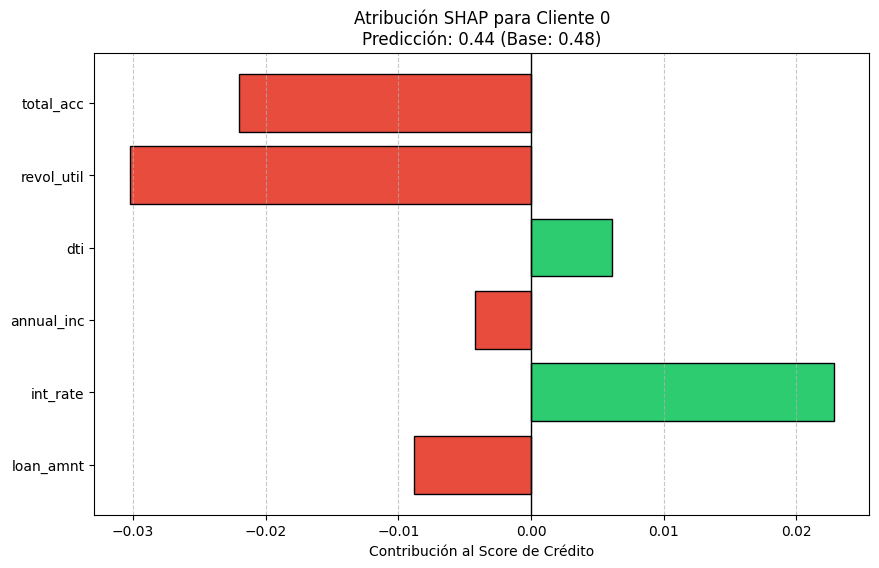


--- TEST DE ESTABILIDAD M2.1 ---
loan_amnt   : Desviación Std = 0.001351
int_rate    : Desviación Std = 0.005695
annual_inc  : Desviación Std = 0.001587
dti         : Desviación Std = 0.003802
revol_util  : Desviación Std = 0.002322
total_acc   : Desviación Std = 0.003758


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)



file_path = 'accepted_2007_to_2018Q4.csv'

cols_to_use = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'revol_util', 'total_acc', 'loan_status'
]

try:
    # Leemos una muestra de 50,000 filas para que Colab no colapse
    df = pd.read_csv(file_path, usecols=cols_to_use, nrows=50000)
    print("Archivo cargado exitosamente.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo {file_path}. Asegúrate de subirlo a Colab.")
    df = pd.DataFrame(np.random.rand(1000, 7), columns=cols_to_use)
    df['loan_status'] = np.where(df['loan_status'] > 0.5, 'Fully Paid', 'Charged Off')

# Preprocesamiento rápido
df = df.dropna()
df['target'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)
features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util', 'total_acc']

X = df[features].values
y = df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)


# Entrenamos el modelo base para el análisis XAI
print("Entrenando modelo Random Forest...")
model_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_rf.fit(X_train, y_train)


class FinancialBridgeXAI:
    def __init__(self, model, reference_data):
        self.model = model
        self.reference_data = reference_data
        self.base_value = float(np.mean(self.model.predict(self.reference_data)))

    def get_shapley_contributions(self, x, n_samples=100):
        x = x.ravel()
        d = len(x)
        phis = np.zeros((n_samples, d))

        for t in range(n_samples):
            perm = np.random.permutation(d)
            z = self.reference_data[np.random.randint(0, len(self.reference_data))].copy()
            x_minus = z.copy()

            for j in range(d):
                idx = perm[j]
                x_plus = x_minus.copy()
                x_plus[idx] = x[idx]

                f_plus = self.model.predict(x_plus.reshape(1,-1))[0]
                f_minus = self.model.predict(x_minus.reshape(1,-1))[0]

                phis[t, idx] = f_plus - f_minus
                x_minus[idx] = x[idx]

        return np.mean(phis, axis=0), self.base_value

def ejecutar_experimentos():
    # Seleccionamos un cliente del set de prueba
    cliente_idx = 0
    x_cliente = X_test[cliente_idx]

    # Referencia para SHAP (usamos 100 muestras del entrenamiento para rapidez)
    xai = FinancialBridgeXAI(model_rf, X_train[:100])

    phi, base = xai.get_shapley_contributions(x_cliente)
    pred = model_rf.predict(x_cliente.reshape(1,-1))[0]

    # Visualización de contribuciones
    plt.figure(figsize=(10, 6))
    colores = ['#2ecc71' if p > 0 else '#e74c3c' for p in phi]
    plt.barh(features, phi, color=colores, edgecolor='black')
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"Atribución SHAP para Cliente {cliente_idx}\nPredicción: {pred:.2f} (Base: {base:.2f})")
    plt.xlabel("Contribución al Score de Crédito")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Evaluación de Estabilidad
    print("\n--- TEST DE ESTABILIDAD M2.1 ---")
    perturbaciones = []
    for i in range(5):
        p_ruido, _ = xai.get_shapley_contributions(x_cliente + np.random.normal(0, 0.01, len(x_cliente)))
        perturbaciones.append(p_ruido)

    estabilidad = np.std(perturbaciones, axis=0)
    for i, f in enumerate(features):
        print(f"{f:12}: Desviación Std = {estabilidad[i]:.6f}")

if __name__ == "__main__":
    ejecutar_experimentos()


=== Benchmark (accuracy / AUC) ===
LogReg (baseline)       acc=0.7201  auc=0.7351
RF plain (black-box)    acc=0.7306  auc=0.7503
RF fair (reweight)      acc=0.7317  auc=0.7503

=== Training time (sec) ===
LogReg:   0.136
RF plain: 5.263
RF fair:  3.539

=== XAI (Shapley) ===
Cliente idx: 0   y=0   grupo(income_high)=1
Pred f(x): 0.5210
Base E[f(Xref)]: 0.6995
Diff: -0.1785
Suma Phi: -0.2080
Eficiencia aprox (tol 0.03): True
Tiempo explicación (sec): 35.314


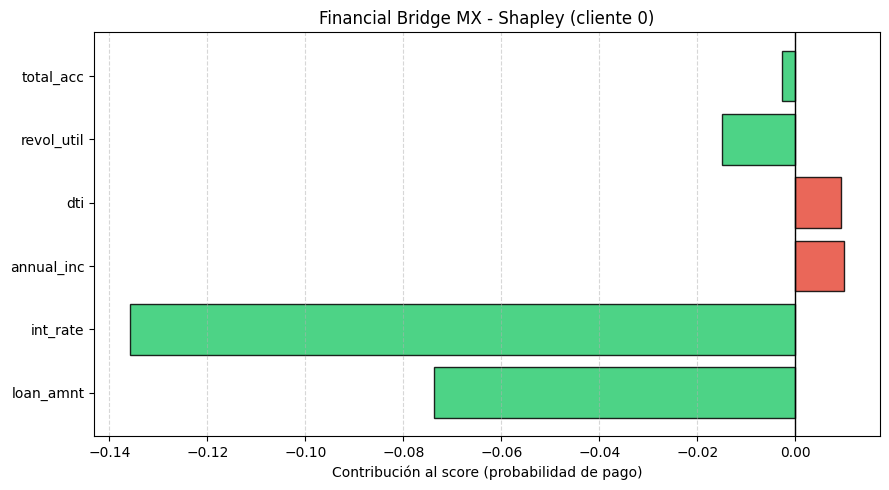


=== Robustness: estabilidad (std de Phi con ruido) ===
loan_amnt   : std=0.007330
int_rate    : std=0.007958
annual_inc  : std=0.001865
dti         : std=0.003638
revol_util  : std=0.001828
total_acc   : std=0.000849


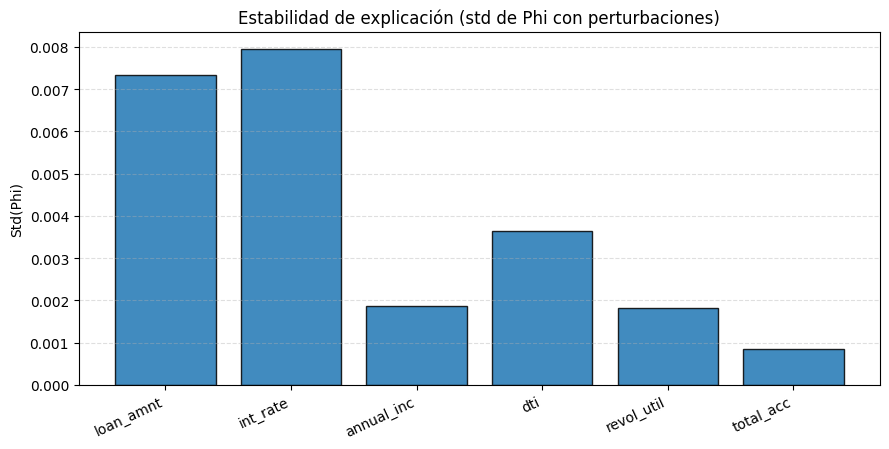


=== Fairness (grupo = income bajo vs alto) ===
RF plain:
  DP diff (|P(approve|g1)-P(approve|g0)|): 0.0381
  TPR g0=0.9044   TPR g1=0.9232   EO diff=0.0188
RF fair (reweight):
  DP diff (|P(approve|g1)-P(approve|g0)|): 0.0363
  TPR g0=0.9065   TPR g1=0.9238   EO diff=0.0173


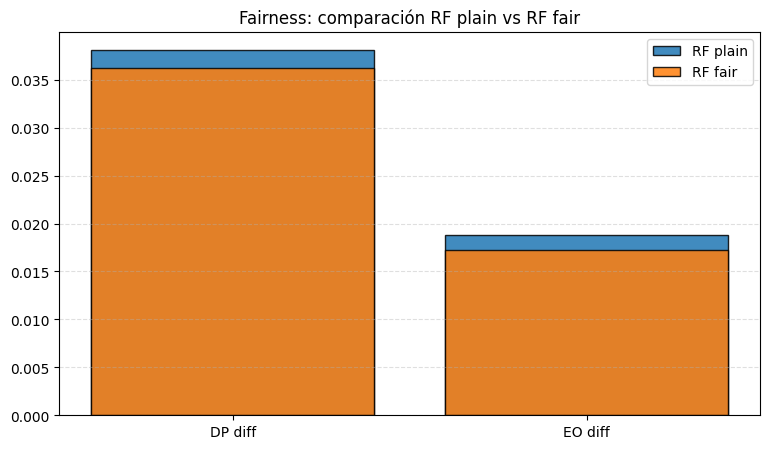


=== Listo ===
Se guardaron outputs en: midterm2_outputs/
 - shap_cliente0.png
 - stability_std.png
 - fairness_compare.png
 - run_log.json


In [ ]:
import os
import json
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# CONFIG
SEED = 42
np.random.seed(SEED)

FILE_PATH = "accepted_2007_to_2018Q4.csv"
NROWS = 50000
REF_N = 200
SHAP_SAMPLES = 80
PERT_K = 6
NOISE_SIGMA = 0.02
OUT_DIR = "midterm2_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) DATA  + preprocessing
cols_to_use = [
    "loan_amnt", "int_rate", "annual_inc", "dti",
    "revol_util", "total_acc", "loan_status"
]

if os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH, usecols=cols_to_use, nrows=NROWS)
else:
    df = pd.DataFrame(np.random.rand(2000, 7), columns=cols_to_use)
    df["loan_status"] = np.where(df["loan_status"] > 0.5, "Fully Paid", "Charged Off")
    df["annual_inc"] *= 120000
    df["loan_amnt"] *= 35000
    df["int_rate"] *= 25
    df["dti"] *= 40
    df["revol_util"] *= 100
    df["total_acc"] *= 40

df = df.dropna()

# target: 1 = pagó, 0 = default/charged off (simple)
df["target"] = (df["loan_status"] == "Fully Paid").astype(int)

features = ["loan_amnt", "int_rate", "annual_inc", "dti", "revol_util", "total_acc"]

X_raw = df[features].values.astype(float)
y = df["target"].values.astype(int)

inc = df["annual_inc"].values.astype(float)
inc_thr = np.median(inc)
g = (inc >= inc_thr).astype(int)  # 0 = income bajo, 1 = income alto

X_train_raw, X_test_raw, y_train, y_test, g_train, g_test = train_test_split(
    X_raw, y, g, test_size=0.2, random_state=SEED, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 2) MODELOS  + benchmark
def fit_logreg(Xtr, ytr):
    m = LogisticRegression(max_iter=200, random_state=SEED)
    m.fit(Xtr, ytr)
    return m

def fit_rf(Xtr, ytr, sample_weight=None):
    # ligero: pocos árboles y profundidad limitada
    m = RandomForestClassifier(
        n_estimators=120, max_depth=6, random_state=SEED, n_jobs=-1
    )
    m.fit(Xtr, ytr, sample_weight=sample_weight)
    return m

def pred_score(model, X):
    # score = prob de "Fully Paid"
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    # fallback
    p = model.predict(X)
    return p.astype(float)

def eval_model(name, model, Xte, yte):
    s = pred_score(model, Xte)
    yhat = (s >= 0.5).astype(int)
    acc = accuracy_score(yte, yhat)
    try:
        auc = roc_auc_score(yte, s)
    except Exception:
        auc = float("nan")
    return {"name": name, "acc": acc, "auc": auc}

t0 = time.perf_counter()
baseline_lr = fit_logreg(X_train, y_train)
t1 = time.perf_counter()

t2 = time.perf_counter()
rf_plain = fit_rf(X_train, y_train, sample_weight=None)
t3 = time.perf_counter()

# fairness extension (simple): reweight para balancear grupos en entrenamiento
w = np.ones(len(y_train), dtype=float)
p0 = np.mean(g_train == 0)
p1 = np.mean(g_train == 1)
w[g_train == 0] = 0.5 / max(p0, 1e-9)
w[g_train == 1] = 0.5 / max(p1, 1e-9)

t4 = time.perf_counter()
rf_fair = fit_rf(X_train, y_train, sample_weight=w)
t5 = time.perf_counter()

res_lr = eval_model("LogReg (baseline)", baseline_lr, X_test, y_test)
res_rf = eval_model("RF plain (black-box)", rf_plain, X_test, y_test)
res_rf_fair = eval_model("RF fair (reweight)", rf_fair, X_test, y_test)

print("\n=== Benchmark (accuracy / AUC) ===")
for r in [res_lr, res_rf, res_rf_fair]:
    print(f"{r['name']:22}  acc={r['acc']:.4f}  auc={r['auc']:.4f}")

print("\n=== Training time (sec) ===")
print(f"LogReg:   {t1 - t0:.3f}")
print(f"RF plain: {t3 - t2:.3f}")
print(f"RF fair:  {t5 - t4:.3f}")

# elegimos el modelo “principal” como caja negra (y el fair como variante)
model_main = rf_plain
model_fair = rf_fair

# 3) XAI (Shapley Monte Carlo - ligero)

class FinancialBridgeXAI:
    def __init__(self, model, ref_X, seed=0):
        self.model = model
        self.ref_X = np.array(ref_X)
        self.rng = np.random.default_rng(seed)

    def explain_shapley(self, x, n_samples=80):
        x = np.array(x).ravel()
        d = len(x)

        base = float(np.mean(pred_score(self.model, self.ref_X)))

        contrib = np.zeros(d, dtype=float)

        for _ in range(n_samples):
            perm = self.rng.permutation(d)
            z = self.ref_X[self.rng.integers(0, len(self.ref_X))].copy()
            x_minus = z.copy()

            for idx in perm:
                x_plus = x_minus.copy()
                x_plus[idx] = x[idx]

                f_plus = float(pred_score(self.model, x_plus.reshape(1, -1))[0])
                f_minus = float(pred_score(self.model, x_minus.reshape(1, -1))[0])

                contrib[idx] += (f_plus - f_minus)
                x_minus[idx] = x[idx]

        phi = contrib / n_samples
        pred = float(pred_score(self.model, x.reshape(1, -1))[0])

        return phi, base, pred

# reference data (pequeño)
ref_X = X_train[:REF_N]
xai = FinancialBridgeXAI(model_main, ref_X, seed=SEED)

# cliente: uno del test
cliente_idx = 0
x_cliente = X_test[cliente_idx]
y_cliente = y_test[cliente_idx]
g_cliente = g_test[cliente_idx]

t_exp0 = time.perf_counter()
phi, base, pred = xai.explain_shapley(x_cliente, n_samples=SHAP_SAMPLES)
t_exp1 = time.perf_counter()

print("\n=== XAI (Shapley) ===")
print(f"Cliente idx: {cliente_idx}   y={y_cliente}   grupo(income_high)={g_cliente}")
print(f"Pred f(x): {pred:.4f}")
print(f"Base E[f(Xref)]: {base:.4f}")
print(f"Diff: {pred - base:.4f}")
print(f"Suma Phi: {np.sum(phi):.4f}")
print(f"Eficiencia aprox (tol 0.03): {np.isclose(np.sum(phi), pred - base, atol=0.03)}")
print(f"Tiempo explicación (sec): {t_exp1 - t_exp0:.3f}")

# plot shap
plt.figure(figsize=(9, 5))
colors = ["#e74c3c" if v > 0 else "#2ecc71" for v in phi]
plt.barh(features, phi, color=colors, edgecolor="black", alpha=0.85)
plt.axvline(0, color="black", linewidth=1)
plt.title("Financial Bridge MX - Shapley (cliente 0)")
plt.xlabel("Contribución al score (probabilidad de pago)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "shap_cliente0.png"), dpi=160)
plt.show()

# 4) ROBUSTNESS
phis = []
for _ in range(PERT_K):
    noise = np.random.normal(0, NOISE_SIGMA, size=len(x_cliente))
    pphi, _, _ = xai.explain_shapley(x_cliente + noise, n_samples=SHAP_SAMPLES)
    phis.append(pphi)

phis = np.array(phis)
stability_std = np.std(phis, axis=0)

print("\n=== Robustness: estabilidad (std de Phi con ruido) ===")
for f, s in zip(features, stability_std):
    print(f"{f:12}: std={s:.6f}")

plt.figure(figsize=(9, 4.6))
plt.bar(features, stability_std, edgecolor="black", alpha=0.85)
plt.title("Estabilidad de explicación (std de Phi con perturbaciones)")
plt.ylabel("Std(Phi)")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stability_std.png"), dpi=160)
plt.show()

# 5) FAIRNESS (métricas simples + comparación RF plain vs RF fair)
def fairness_metrics(model, Xte, yte, gte):
    s = pred_score(model, Xte)
    yhat = (s >= 0.5).astype(int)

    # Demographic Parity: diferencia en tasa de aprobación
    p0 = np.mean(yhat[gte == 0]) if np.any(gte == 0) else np.nan
    p1 = np.mean(yhat[gte == 1]) if np.any(gte == 1) else np.nan
    dp_diff = abs(p1 - p0)

    # Equal Opportunity: diferencia en TPR (solo positivos reales)
    def tpr(group):
        mask = (gte == group) & (yte == 1)
        if np.sum(mask) == 0:
            return np.nan
        return np.mean(yhat[mask] == 1)

    tpr0 = tpr(0)
    tpr1 = tpr(1)
    eo_diff = abs(tpr1 - tpr0) if (not np.isnan(tpr0) and not np.isnan(tpr1)) else np.nan

    return {"dp_diff": dp_diff, "tpr0": tpr0, "tpr1": tpr1, "eo_diff": eo_diff}

fm_plain = fairness_metrics(model_main, X_test, y_test, g_test)
fm_fair = fairness_metrics(model_fair, X_test, y_test, g_test)

print("\n=== Fairness (grupo = income bajo vs alto) ===")
print("RF plain:")
print(f"  DP diff (|P(approve|g1)-P(approve|g0)|): {fm_plain['dp_diff']:.4f}")
print(f"  TPR g0={fm_plain['tpr0']:.4f}   TPR g1={fm_plain['tpr1']:.4f}   EO diff={fm_plain['eo_diff']:.4f}")

print("RF fair (reweight):")
print(f"  DP diff (|P(approve|g1)-P(approve|g0)|): {fm_fair['dp_diff']:.4f}")
print(f"  TPR g0={fm_fair['tpr0']:.4f}   TPR g1={fm_fair['tpr1']:.4f}   EO diff={fm_fair['eo_diff']:.4f}")

plt.figure(figsize=(7.8, 4.6))
plt.bar(["DP diff", "EO diff"], [fm_plain["dp_diff"], fm_plain["eo_diff"]], edgecolor="black", alpha=0.85, label="RF plain")
plt.bar(["DP diff", "EO diff"], [fm_fair["dp_diff"], fm_fair["eo_diff"]], edgecolor="black", alpha=0.85, label="RF fair")
plt.title("Fairness: comparación RF plain vs RF fair")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fairness_compare.png"), dpi=160)
plt.show()

# 6) GOVERNANCE (logging básico + artefactos)
run_info = {
    "seed": SEED,
    "nrows_loaded": int(min(NROWS, len(df))),
    "features": features,
    "target_definition": "1=Fully Paid, 0=Other",
    "group_definition": "income_high = annual_inc >= median(annual_inc)",
    "models": {
        "baseline_lr": res_lr,
        "rf_plain": res_rf,
        "rf_fair": res_rf_fair
    },
    "train_time_sec": {
        "logreg": float(t1 - t0),
        "rf_plain": float(t3 - t2),
        "rf_fair": float(t5 - t4)
    },
    "xai": {
        "ref_n": REF_N,
        "shap_samples": SHAP_SAMPLES,
        "explain_time_sec": float(t_exp1 - t_exp0),
        "efficiency_ok": bool(np.isclose(np.sum(phi), pred - base, atol=0.03))
    },
    "robustness": {
        "pert_k": PERT_K,
        "noise_sigma": NOISE_SIGMA,
        "stability_std_mean": float(np.mean(stability_std))
    },
    "fairness": {
        "rf_plain": fm_plain,
        "rf_fair": fm_fair
    },
    "outputs": {
        "shap_plot": os.path.join(OUT_DIR, "shap_cliente0.png"),
        "stability_plot": os.path.join(OUT_DIR, "stability_std.png"),
        "fairness_plot": os.path.join(OUT_DIR, "fairness_compare.png")
    }
}

with open(os.path.join(OUT_DIR, "run_log.json"), "w") as f:
    json.dump(run_info, f, indent=2)

print("\n=== Listo ===")
print(f"Se guardaron outputs en: {OUT_DIR}/")
print(" - shap_cliente0.png")
print(" - stability_std.png")
print(" - fairness_compare.png")
print(" - run_log.json")